TASK #3 - A total of 40 objects were kept for further analysis
TASK#5 - SDSS query found magnitudes for 39 of the 40 objects


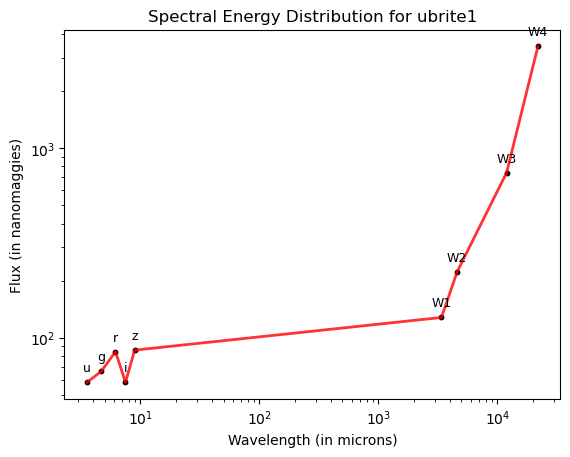

	This object is classified as a STAR, but is at redshift of 1.03, which is not in our galaxy. It's spectrum is labeled as a QSO 
    which makes much more sense. This object was selected because it has a large flux in the u-band, and its W2 flux is significantly
    larger than its W1 flux (this comes from the constraint that W1-W2 > 0.5, which traces hot dust emission). Coupled with the fact that
    we masked out all objects with low r_band emission. It is not surprising that this object that is bright in the optical and surrounded 
    by hot dust happens to be an extragalactic QSO



Script finished in 17.26 seconds
When I run this script on my office computer from scratch (ret1) I sometimes get times as low as 40 seconds, and sometimes 250 seconds 
if you get a time that is larger than a minute, try running again and see if it changes


In [5]:
import time
start_time = time.time()#TJ get exact start time (for computing total execution time)
import os
import sys
from astropy.table import Table, vstack, Column, Row
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from scipy.spatial import cKDTree
import numpy as np
import requests
import matplotlib.pyplot as plt

def get_sdss_mags(ra, dec, radius = 1.2/3600):
    '''query SDSS navigator for objects within given radius of ra, dec location

    Note that the website will throttle rapid requests and may take longer to do every 5th or so query.
    This automatic throttling means we dont need to sleep for 1 second between queries though ;)

    -------------

    Parameters
    -------------
    ra :  type = float - right ascension in degrees of query object
    dec :  type = float - declination in degrees of query object
    radius (optional, defaults to 1.2 arcseconds) : 
    retry (optional, defaults to false) : if set to True, if no object is returned 
    
    Returns
    -------------
    table with only the columns that we wanted to keep
    '''

    #TJ define SDSS query url

    url = f"http://skyserver.sdss.org/dr16/SkyServerWS/SearchTools/SqlSearch?cmd=SELECT+TOP+1+u,i,ra,dec+FROM+PhotoPrimary+WHERE+ra BETWEEN {ra-radius} AND {ra+radius}+AND+dec BETWEEN {dec-radius} AND {dec+radius}&format=json"
    response = requests.get(url).json() #TJ perform request and parse result
    if response[0]['Rows'] != []: #TJ if an object is returned, function returns the u and i magnitudes
        return response[0]['Rows'][0]['u'], response[0]['Rows'][0]['i']
    else:
        return np.nan, np.nan


def read_partial_fits(filepath, kept_column_names):
    '''read in table ignoring any columns that arent needed (this saves memory and time compared to reading in EVERY column
    -------------

    Parameters
    -------------
    filepath :  type = str - string representing path to .fits files you want to read in
    kept_column_names :  type = list - list of strings corresponding to which columns need to be read in. All other columns are ignored
    
    Returns
    -------------
    table with only the columns that we wanted to keep
    '''
    
    with fits.open(filepath) as hdul:
        data = hdul[1].data  #TJ read in all data
        filtered_data = {col: data[col] for col in kept_column_names} #TJ filter data to only keep necessary columns
        return Table(filtered_data)



def add_mag_column(original_table, fluxes):
    '''Add one new column in table for every column with name "FLUX_x". New column will be named "x_mag".
    
    -------------

    Parameters
    -------------
    table :  type = astropy.table - table with at least one column name "FLUX_x"
    fluxes : type = list - list of strings corresponding to which columns of fluxes you want to add a corresponding magnitude column

    Returns
    -------------
    Original table, with all fluxes converted to magnitudes
    '''

    for flux_col in fluxes:
        band = flux_col.split('_')[1] #TJ extract column name, "FLUX_R" will have the "R" pulled out and used to name new column "R_mag"
        new_col_name = f"{band}_mag"  #TJ define new column e.g., 'G_mag' for original "FLUX_G"

        original_table[new_col_name] = 22.5 - 2.5*np.log10(original_table[flux_col]) #TJ convert flux to magnitude
    return original_table





def cross_match(match_all_these, find_matches_from_here, max_sep=(1/3600)):
    '''find objects in the find_matches_from_here table that are the closest RA,DEC to every object in the match_all_these table

    -------------

    Parameters
    -------------
    match_all_these :  type = astropy.table - table with columns for "RA" and "DEC"
    fine_matches_from_here :  type = astropy.table - table with columns for "RA" and "DEC"
    max_sep (optional, defaults to 1 arcsecond) : type = float - fail to match objects if the closest any object gets is this number of degrees away                  
    
    Returns
    -------------
    table with only the rows in find_matches_from_here table that correspond to the rows in the match_all_these table
    '''

    #TJ convert RA/DEC to Cartesian coordinates for efficient searching without distortion, stack and transpose so cKDTree can efficiently search
    survey_coords = SkyCoord(find_matches_from_here['RA'], find_matches_from_here['DEC'], unit=u.deg)
    survey_xyz = np.vstack(survey_coords.cartesian.xyz).T
    obs_coords = SkyCoord(match_all_these['RA'], match_all_these['DEC'], unit=u.deg)
    obs_xyz = np.vstack(obs_coords.cartesian.xyz).T
    
    #TJ build a KDTree for the survey table
    tree = cKDTree(survey_xyz)

    #TJ query the tree for the nearest neighbor for each object in obs_table, this takes Log(N) time so hopefully this doesnt take too long
    indices = tree.query(obs_xyz)[1] #TJ first output is distance in euclidian space, which is useless, [1] is the index of the match
    #TJ compute separation in degrees using dot product (slightly faster than astropy.separation on every object)
    separations = np.degrees(np.arccos(np.sum(obs_xyz * survey_xyz[indices], axis=1))).value
    
    #TJ filter out objects that dont need to be included
    valid_matches = (separations < max_sep) & ((find_matches_from_here['W1_mag'][indices] - find_matches_from_here['W2_mag'][indices]) >= 0.5) & (find_matches_from_here['R_mag'][indices] < 22)

    #TJ grab all the selected entries
    filtered_match_all_these = match_all_these[valid_matches]
    filtered_matches_table = find_matches_from_here[indices[valid_matches]]
    return filtered_match_all_these, filtered_matches_table






if __name__ == "__main__":
    #TJ define filepath to FIRST dataset
    FIRST_filepath = '/d/scratch/ASTR5160/data/first/first_08jul16.fits'
    FIRST_data = read_partial_fits(FIRST_filepath, ["RA", "DEC"]) #TJ we only need ra and dec from this table.
    center_of_field = SkyCoord(163, 50, unit = (u.deg, u.deg)) #TJ Define center of field, only objects within 3 degrees of this will be kept
    all_obj_loc = SkyCoord(FIRST_data["RA"], FIRST_data["DEC"], unit = (u.deg, u.deg))
    
    in_survey = FIRST_data[all_obj_loc.separation(center_of_field) < 3 * u.deg] #TJ extract only relevent objects from the FIRST file
    #TJ rel_objs now is a table of only objects within the astronomer's survey
    
    sweep_directory = '/d/scratch/ASTR5160/data/legacysurvey/dr9/north/sweep/9.0/' #TJ assign necessary sweep file directories
    sweep_files = [sweep_directory + 'sweep-150p045-160p050.fits', sweep_directory + 'sweep-160p045-170p050.fits', 
                       sweep_directory + 'sweep-150p050-160p055.fits', sweep_directory + 'sweep-160p050-170p055.fits'] #TJ assign needed sweep file paths
    
    #TJ only read in columns we actually need, this table has WAYYYY too many columns and it might slow down computation time.
    sweep_columns_to_keep = ['RA', 'DEC', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4']
    
    # Read only these columns from all sweep files
    sweep_data = vstack([read_partial_fits(file, sweep_columns_to_keep) for file in sweep_files])
    for flux_col in ['FLUX_W1', 'FLUX_W2', 'FLUX_R']: #TJ prevent attempting to take log10 of negative number by replacing with a small positive number
        sweep_data[flux_col] = np.where(sweep_data[flux_col] <= 0, 1e-10, sweep_data[flux_col]) 
    sweep_data = add_mag_column(sweep_data, ["FLUX_R", "FLUX_W1", "FLUX_W2"]) #TJ add magnitude columns for g, W1, and W2

    rel_FIRST_data, rel_sweep_data = cross_match(in_survey, sweep_data) #TJ perform cross match
    print(f"TASK #3 - A total of {len(rel_FIRST_data)} objects were kept for further analysis")

    #TJ add columns for SDSS query results
    rel_sweep_data.add_column(Column(name='u_mag', data=np.nan * len(rel_sweep_data)))
    rel_sweep_data.add_column(Column(name='i_mag', data=np.nan * len(rel_sweep_data)))
    for row in rel_sweep_data:
        ra, dec = row['RA'], row['DEC'] #TJ assign ra and dec values for query
        row["u_mag"], row["i_mag"] = get_sdss_mags(ra, dec) #TJ assign actual values for the u and i band magnitudes
    
    nan_count = np.sum(np.isnan(rel_sweep_data['u_mag'])) #TJ count how many nan values are in the set
    #TJ the total length, minus number of nans is the number of successful queries from SDSS
    
    print(f'TASK#5 - SDSS query found magnitudes for {len(rel_sweep_data) - nan_count} of the {len(rel_sweep_data)} objects')
    
    #TJ I think there is a typo in the assignment and this is actually asking which of these cross-matched objects is the brightest.
    #TJ I ran a much more time consuming analysis on all 2637 FIRST objects that are in the astronomer's survey, and it returned
    #TJ an object brighter in the u_band. The brightest object is actually sweep_data[2040637] which has a u_mag of 15.07173
    #TJ but this object has a W1-W2 color of -0.10889053 which did not meet the minimum value of 0.5 to be selected.
    
    mask = ~np.isnan(rel_sweep_data["u_mag"]) #TJ mask out the nan(s) in the table so they dont get selected as the lowest value
    global_idx = np.where(mask)[0][np.argmin(rel_sweep_data["u_mag"][mask])] #TJ find the index in the full table that has the lowest u_mag
    
    ubrite1 = {col: rel_sweep_data[col][global_idx] for col in rel_sweep_data.colnames} #TJ create a dictionary that is JUST ubrite1

    ubrite1['FLUX_U'] = 10 ** ( -(ubrite1["u_mag"]-22.5)/2.5) #TJ add flux values for u and i bands
    ubrite1['FLUX_I'] = 10 ** ( -(ubrite1["u_mag"]-22.5)/2.5)
    
    positions = [[3.551, ubrite1["FLUX_U"]],
                 [4.686, ubrite1["FLUX_G"]], 
                 [6.165, ubrite1["FLUX_R"]], 
                 [7.481, ubrite1["FLUX_I"]], 
                 [8.931, ubrite1["FLUX_Z"]], 
                 [3400, ubrite1["FLUX_W1"]], 
                 [4600, ubrite1["FLUX_W2"]], 
                 [12000, ubrite1["FLUX_W3"]],
                 [22000, ubrite1["FLUX_W4"]]]                                 
    band_labels = ['u', 'g', 'r', 'i', 'z', 'W1', 'W2', 'W3', 'W4'] #TJ these will label the graph appropriately
    wavelengths = np.array([p[0] for p in positions]) #TJ pick out wavelengths and fluxes
    fluxes = np.array([p[1] for p in positions])
    
    plt.plot(wavelengths, fluxes, '-', color='red', linewidth=2, alpha=0.8) #TJ plot a line connecting each flux measurement
    plt.scatter(wavelengths, fluxes, s=10, color='black') #TJ put dots on the actual data points
    for w, f, label in zip(wavelengths, fluxes, band_labels):
        plt.text(w, f*1.1, label, ha='center', va='bottom', fontsize=9) #TJ label all the dots with their respective bands
    plt.xscale('log') #TJ change x-axis to log space so the ugriz arent on top of each other
    plt.yscale('log') #TJ change y-axis to log space so the ugriz arent on top of each other
    plt.xlabel('Wavelength (in microns)')
    plt.ylabel('Flux (in nanomaggies)')
    plt.title('Spectral Energy Distribution for ubrite1')
    plt.show()    

    print('''\tThis object is classified as a STAR, but is at redshift of 1.03, which is not in our galaxy. It's spectrum is labeled as a QSO 
    which makes much more sense. This object was selected because it has a large flux in the u-band, and its W2 flux is significantly
    larger than its W1 flux (this comes from the constraint that W1-W2 > 0.5, which traces hot dust emission). Coupled with the fact that
    we masked out all objects with low r_band emission. It is not surprising that this object that is bright in the optical and surrounded 
    by hot dust happens to be an extragalactic QSO''')
    
    #TJ get finish time and print dt for execution
    elapsed_time = time.time() - start_time
    print() #TJ adding lines to separate printed statements
    print()
    print()
    print(f"Script finished in {elapsed_time:.2f} seconds")

    print('When I run this script on my office computer (ret1) from scratch, I sometimes get times as low as 40 seconds, and sometimes 250 seconds \nif you get a time that is larger than a minute, try running again and see if it changes')